# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Explaionary Data Analysis

In [1]:
# import 
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.model_selection import train_test_split



from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

##  Read in data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

##  1- Portfolio dataset

In [3]:
# view the portfolio dataset
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# view the shape of dateset
portfolio.shape

(10, 6)

In [5]:
# view the dtypes 
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [6]:
# checking the columns
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [7]:
# quick check on missing value in dataset
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [8]:
# Statistics for the Portfolio Dataframe
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [9]:
# checking for duplicates
portfolio.columns.duplicated().sum()

0

In [10]:
# checking the offer types the customer can receive
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

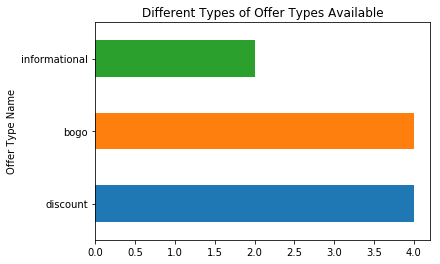

In [11]:
# Types of offer available 
a1 = portfolio.offer_type.value_counts()
a1.plot(kind='barh')
sns.set(style="darkgrid")
plt.ylabel('Offer Type Name')
plt.title('Different Types of Offer Types Available');

This plot is showing the different type of the Offers available

In [12]:
# Different Type of Channels
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [13]:
# the number of unique offer in dataset
portfolio.id.nunique()

10

In [14]:
# count the number of offer by offer type
portfolio.groupby('offer_type').id.count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

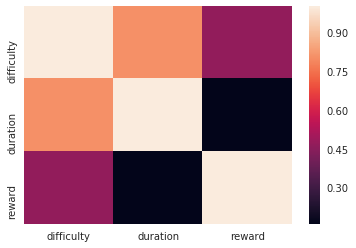

In [15]:
# Heatmaps for the Portfolio
corr = portfolio.corr()
sns.heatmap(corr)

This Dataset contains 6 columns and 10 rows . There is no duplicates and null values in the Portfolio dataset .Column of (types of offers) included :BOGO'(Buy One Get One free), 'informational', and 'discount' .There are FOUR offers Classified as : "bogo" , FOUR offers classified as : "discount" and TWO offers classified as : "informational". There are FOUR different types of channels - web, social, mobile, email.

_______________________________________________________________________________________________________________________________

___________________________________________________________________________________________________________________________

##  2. Profile dataset

In [16]:
# view the profile dataset which contains demographic information
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [17]:
# Statistics for the Profile Dataframe
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [18]:
# checking the columns' titles and datatypes 
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [19]:
# quick overview on null values in dataset
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [20]:
# percentage of mssing value
profile.isnull().sum()/profile.shape[0]

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [21]:
# checking for duplicates
profile.columns.duplicated().sum()

0

In [22]:
# the number of user id
profile['id'].nunique()

17000

In [23]:
# number of missing values in age column
profile[profile.age==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [24]:
# check if the rows which have missing age also have missing gender and income
profile[profile.age==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [25]:
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [26]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

Text(0,0.5,'Count')

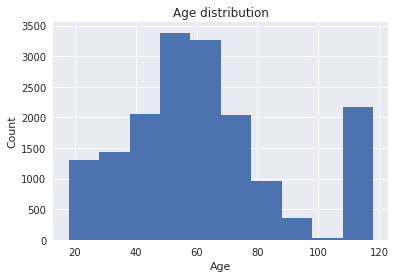

In [27]:
# age distribution
profile.age.hist()
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")

In [28]:
# checking the unique values of the 'gender' column
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [29]:
# checking the number of Male and Famale customers 
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

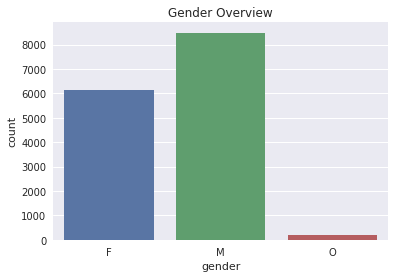

In [30]:
# Plotting the bar plot for the count of based on the gender
plt.title('Gender Overview')
sns.countplot(x='gender', data=profile)

In [31]:
# Values having maximum, minimum and average income group
print("Maximum value in the income group --->", profile['income'].max())

Maximum value in the income group ---> 120000.0


In [32]:
# Values having maximum, minimum and average income group
print("Miminum value in the income group --->", profile['income'].min())

Miminum value in the income group ---> 30000.0


In [33]:
# Values having maximum, minimum and average income group
print("Mean value in the income group --->", profile['income'].mean())

Mean value in the income group ---> 65404.9915683


Text(0,0.5,'Count')

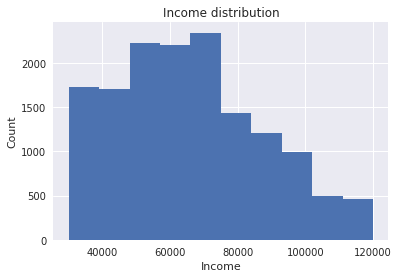

In [34]:
# get a quick view on income distribution
profile.income.hist()
plt.title("Income distribution")
plt.xlabel("Income")
plt.ylabel("Count")

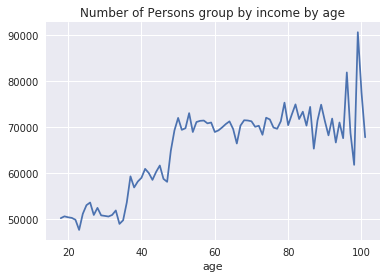

In [35]:
# Plotting the graphs based on the income group by age
plt.title('Number of Persons group by income by age')
profile.groupby(['age'])['income'].mean().plot(kind='line');

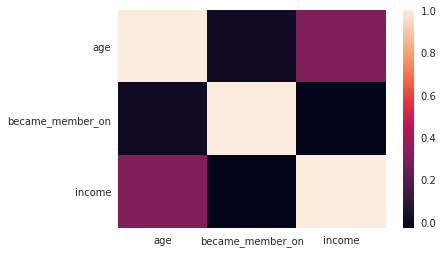

In [36]:
# Heatmaps for the profile
corr1 = profile.corr()
sns.heatmap(corr1)

This Dataset contains 5 Columns AND 17000 rows .Has 2175 missing values on : 'gender' and has 2175 missing values on  'income' variables . The dataset has no duplicated rows .Customers range in age from 18 to 101. Although those 2175 consumers were enrolled at the age of 118, I still consider this age to be an anomaly because it appears that something is incorrect with these 2175 rows in the dataset .Customers with age 118 have a missing values in 'gender' or 'income.' this needs to be cleaned ,in the Data Pre-processing Section .Customers fall into one of three 'gender' categories, according to the available data ( M, F, and O).Male Customers (8484 men) are more than Female Customers(6129 women) and , 212 customers have selected "O" as their gender .'became-member-on' column needs date formatting.

_______________________________________________________________________________________________________________________________

____________________________________________________________________________________________________________________________

## 3. Transcript Dataset

In [37]:
# view the transcript dataset
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [38]:
# Statistics for the Transcript Dataframe
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [39]:
# shape of transcript
transcript.shape

(306534, 4)

In [40]:
# checking the columns' titles and datatypes 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [41]:
# quick check on missing value
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [42]:
# checking for duplicates
transcript.columns.duplicated().sum()

0

In [43]:
# Checking the distinct events of the transcript
print("The distinct events of the transcript --->", transcript.event.unique())

The distinct events of the transcript ---> ['offer received' 'offer viewed' 'transaction' 'offer completed']


In [44]:
# quick chekc on the event distribution
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

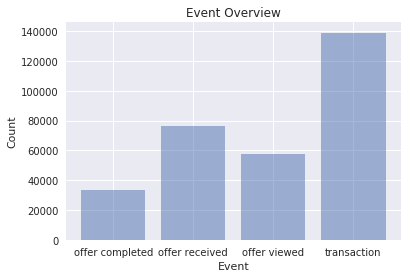

In [45]:
objects = ('offer completed', 'offer received', 'offer viewed', 'transaction')
y_pos = np.arange(len(objects))
performance = list(transcript.groupby('event').person.count())

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.xlabel('Event')
plt.title('Event Overview')

plt.show()

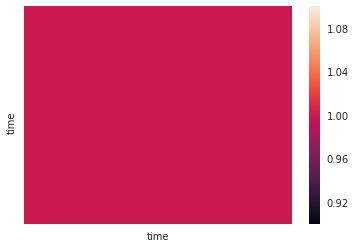

In [46]:
corr2 = transcript.corr()
sns.heatmap(corr2)

This Dataset contains 4 Columns AND 306534 rows. The dataset has no duplicated rows nor missing values .There are Four types of the offers at the transaction level: 1-offer received , 2- offer completed , 3- transaction , 4-offer viewed.


# Data Processing

## Portfolio Dataset

The following steps are involved in the data processing:

1-  Change the name of the 'id' column to 'offer_id'. 

2- Change the 'duration' column's unit of measurement from days to hours 

3-Using the MinMaxScaler, normalize the 'difficulty' and'reward' features.

4-Using One hot encoding for values in feature channels , that it can be represented in the binary form of the 0 and 1 values then remove the 'channels' column from the table.

5-Replace 'offer_ id' with more simple ids. 

6-Replace 'offer type' with integers representing each offer type

________________________________________________________________________________________________________________________________

Rename 'id' column to 'offer_id'.

In [47]:
# Change name of feature id to offer_id
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

Change the unit of 'duration' column from days to hours.

In [48]:
# Convert time feature from days to hours
portfolio['duration'] = portfolio['duration']*24

Normalize 'difficulty' and 'reward' features using the MinMaxScaler.

In [49]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['difficulty','reward']

#features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
portfolio[numerical] = scaler.fit_transform(portfolio[numerical])

# Show an example of a record with scaling applied
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",0.50,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.0
1,"[web, email, mobile, social]",0.50,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.0
2,"[web, email, mobile]",0.00,96,3f207df678b143eea3cee63160fa8bed,informational,0.0
3,"[web, email, mobile]",0.25,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0.5
4,"[web, email]",1.00,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0.5


Create dummy variables from the 'channels' column using one-hot encoding then Drop the 'channels' column.

In [50]:
# checking the channels options to decide on the number and the titles of the dummy variables to be created
portfolio['channels'].head()

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
Name: channels, dtype: object

In [51]:
# Make separate columns for values in feature channels list
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: int(1) if 'web' in x else int(0))
portfolio['channel_email'] = portfolio['channels'].apply(lambda x: int(1) if 'email' in x else int(0))
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: int(1) if 'mobile' in x else int(0))
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: int(1) if 'social' in x else int(0))


In [52]:
# checking that the dummy variables are correctly created 
portfolio[['channels','channel_email','channel_mobile','channel_web','channel_social']].head()

,channels,channel_email,channel_mobile,channel_web,channel_social
0,"[email, mobile, social]",1,1,0,1
1,"[web, email, mobile, social]",1,1,1,1
2,"[web, email, mobile]",1,1,1,0
3,"[web, email, mobile]",1,1,1,0
4,"[web, email]",1,0,1,0


from sklearn.preprocessing import MultiLabelBinarizer

In [53]:
# Drop channels column
portfolio.drop(columns=['channels'],axis=1, inplace=True)

Replace the 'offer_id' by more easy ids

In [54]:

replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(portfolio['offer_id'].astype('category').cat.categories.tolist(),list(range(1,len(portfolio['offer_id'])+1)))}}

In [55]:
replace_map_comp_offer_id

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
  '2298d6c36e964ae4a3e7e9706d1fb8c2': 2,
  '2906b810c7d4411798c6938adc9daaa5': 3,
  '3f207df678b143eea3cee63160fa8bed': 4,
  '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
  '5a8bc65990b245e5a138643cd4eb9837': 6,
  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
  'ae264e3637204a6fb9bb56bc8210ddfd': 8,
  'f19421c1d4aa40978ebb69ca19b0e20d': 9,
  'fafdcd668e3743c1bb461111dcafc2a4': 10}}

Replace the 'offer_type' by integers representing each offer type

In [56]:
# replacing the categorical values in the 'offer_id' column by numberical values
portfolio.replace(replace_map_comp_offer_id, inplace=True)

In [57]:
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(portfolio['offer_type'].astype('category').cat.categories.tolist(),list(range(1,len(portfolio['offer_type'])+1)))}}

In [58]:
# checking the new offer types labels
print(replace_map_comp_offer_type)

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}


In [59]:
# replacing the categorical values in the 'offer_type' column by numberical values
portfolio.replace(replace_map_comp_offer_type, inplace=True)

In [60]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
difficulty        10 non-null float64
duration          10 non-null int64
offer_id          10 non-null int64
offer_type        10 non-null int64
reward            10 non-null float64
channel_web       10 non-null int64
channel_email     10 non-null int64
channel_mobile    10 non-null int64
channel_social    10 non-null int64
dtypes: float64(2), int64(7)
memory usage: 800.0 bytes


In [61]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,0.50,168,8,1,1.0,0,1,1,1
1,0.50,120,5,1,1.0,1,1,1,1
2,0.00,96,4,3,0.0,1,1,1,0
3,0.25,168,7,1,0.5,1,1,1,0
4,1.00,240,1,2,0.5,1,1,0,0


_________________________________________________________________________________________________________________________________

## Profile Dataset

1. 'id' preprocessing feature:

1- Change the name of the 'id' column to 'customer_id'.

2- Replace the string values for 'customer id' with the simplest numerical values .

2. 'Age' preprocessing feature:

1- NaN value should be substituted for age = 118.

2- Filling the NaN values for the "age" , "income" and "gender"columns with the mean average values

3- Change the 'age' and 'income' columns' data types to 'int'.

4- Create a new column called 'age group' that contains the age group of each customer.

5- Replace the categorical label 'age group' with a numerical label

3. 'Income' preprocessing feature:

1- Create a new column called 'income range' that contains the income-range that the customer's earnings fall into.

2-Replace the categorical label 'income range' with a number label 

4. 'gender' preprocessing feature:

1-Replace the 'gender' labels with numerical label.

5. 'became_member_on' preprocessing feature:

1-Formatting the 'became member on' column in the Profile dataset

2-Create a new column 'start _year' that displays the year in which the client joins a member.

3-Create a new column 'membership days' that displays the number of days since the client become a member

4-Create a new column called 'member type' to reflect the type of member: new, regular, or loyal, based on the number of days he has been a member.

5-Replace the categorical label 'member type' with a numerical label


In [62]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Preprocessing 'id' Feature

In [63]:
# profile :renaming 'id' column name to 'customer_id'.
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [64]:
# replacing the 'customer_id' string values  with easiest numerical values
labels_customer_id = profile['customer_id'].astype('category').cat.categories.tolist()
replace_map_comp_customer_id = {'customer_id' : {k: v for k,v in zip(labels_customer_id,list(range(1,len(labels_customer_id)+1)))}}

In [65]:
# replacing the  categorical labels in 'customer_id' column with numerical labels
profile.replace(replace_map_comp_customer_id, inplace=True)

Preprocessing 'age' Feature

In [66]:
# profile: change age value 118 to nan.
profile.age.replace(118, np.nan, inplace=True)

In [67]:
# checking that the age = 118 does not longer exist, the output should be nothing 
profile[profile['age'] == 118]

,age,became_member_on,gender,customer_id,income


In [68]:
# checking that the rows with missing values(NaNs) 
profile.isna().sum()

age                 2175
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

In [69]:
# Filling the NaN values with the mean age of the column
profile['age'] = profile['age'].fillna(profile['age'].mean())

In [70]:
# Filling the NaN values for the income column with the mean average value
profile['income'] = profile['income'].fillna(profile['income'].mean())

In [71]:
# Replacing missing gender values with mode which is the most frequent gender
gender_mode = profile['gender'].mode()[0]
profile['gender'] = profile['gender'].fillna(gender_mode)

In [72]:
# checking that the rows with missing values(NaNs) 
profile.isna().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
dtype: int64

In [73]:
# changing the datatype of 'age' and 'income' columns to 'int'
profile[['age','income']] = profile[['age','income']].astype(int)

In [74]:
# Adding Age Group column
profile.loc[(profile.age < 20) , 'age_group'] = 'Under 20'
profile.loc[(profile.age >= 20) & (profile.age <= 45) , 'age_group'] = '20-45'
profile.loc[(profile.age >= 46) & (profile.age <= 60) , 'age_group'] = '46-60'
profile.loc[(profile.age >= 61) , 'age_group'] = '61-80'

In [75]:
# checking the unique values in the newely created column
profile['age_group'].head()

0    46-60
1    46-60
2    46-60
3    61-80
4    46-60
Name: age_group, dtype: object

In [76]:
# replacing the 'age_group' categorical labels by numerical labels
labels_age_group = profile['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}

In [77]:
print(replace_map_comp_age_group)

{'age_group': {'20-45': 1, '46-60': 2, '61-80': 3, 'Under 20': 4}}


In [78]:
# replace categorical labels in 'age_group' column with numerical labels
profile.replace(replace_map_comp_age_group, inplace=True)

In [79]:
# confirming that the replacement has been correctly performed 
profile['age_group'].head()

0    2
1    2
2    2
3    3
4    2
Name: age_group, dtype: int64

In [80]:
profile.head()

,age,became_member_on,gender,customer_id,income,age_group
0,54,20170212,M,6962,65404,2
1,55,20170715,F,399,112000,2
2,54,20180712,M,3747,65404,2
3,75,20170509,F,7997,100000,3
4,54,20170804,M,10736,65404,2



Preprocessing 'income' Feature

In [81]:
# creating a new column representing the age group to which the customer belongs 
profile['income_range'] = pd.cut(profile['income'], bins=[29999, 60000, 90000, 120001],labels=['average', 'above-average', 'high'])

In [82]:
# replacing the 'income_range' categorical labels by numerical labels
labels_income_range = profile['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_range = {'income_range' : {k: v for k,v in zip(labels_income_range,list(range(1,len(labels_income_range)+1)))}}

In [83]:
# checking the categorical labels and its corresponding numerical labels for 'income_range' column
replace_map_comp_income_range

{'income_range': {'average': 1, 'above-average': 2, 'high': 3}}

In [84]:
# replacing categorical labels in 'income_range' column with numerical labels
profile.replace(replace_map_comp_income_range, inplace=True)

Preprocessing 'gender' Feature

In [85]:
# replacing the 'gender' categorical labels with coressponding numerical label
labels_gender = profile['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
profile.replace(replace_map_comp_gender, inplace=True)

In [86]:
replace_map_comp_gender 

{'gender': {'F': 1, 'M': 2, 'O': 3}}


Preprocessing 'membership_days' Feature

In [87]:
# changing the datatype of 'became_member_on' column from int to date and put it in the appropriate format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

# adding a new column 'start_year', that will present the year at which the customer became a member
profile['membership_year'] = profile['became_member_on'].dt.year


# adding a new column 'membership_days' ,that will present the number of days since the customer become a member
profile['membership_days'] = datetime.datetime.today().date() - profile['became_member_on'].dt.date

# removing the 'days' unit
profile['membership_days'] = profile['membership_days'].dt.days

In [88]:
# creating a new column 'member_type' representing the type of the member: new, regular or loyal depending on the number of his 'membership_days'
profile['member_type'] = pd.cut(profile['membership_days'], bins=[390, 1000, 1600, 2500],labels=['new', 'regular', 'loyal'])

In [89]:
# replacing the 'member_type' categorical labels by numerical labels
labels_member_type = profile['member_type'].astype('category').cat.categories.tolist()
replace_map_comp_member_type = {'member_type' : {k: v for k,v in zip(labels_member_type,list(range(1,len(labels_member_type)+1)))}}

In [90]:
# checking the numerical label and its corresponding categorical label
print(replace_map_comp_member_type)

{'member_type': {'new': 1, 'regular': 2, 'loyal': 3}}


In [91]:
# replacing categorical labels in 'member_type' column with numerical labels
profile.replace(replace_map_comp_member_type, inplace=True)

In [92]:
# dropping 'age','income', 'became_member_on' and 'membership_days' columns, since they are no longer needed.
profile.drop(columns = ['age','income','became_member_on', 'membership_days'], axis=1, inplace=True)

In [93]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
gender             17000 non-null int64
customer_id        17000 non-null int64
age_group          17000 non-null int64
income_range       17000 non-null int64
membership_year    17000 non-null int64
member_type        15807 non-null float64
dtypes: float64(1), int64(5)
memory usage: 797.0 KB


## Transcript Dataset



Steps that need to be done:

   

    Preprocess 'person' Feature:
        1- column to cutsomer_id for better readability
        2-Replace the categorical values in 'customer_id' column by numerical values 
        3- create separate columns for amount and offer_id and reward from value col
        4-offer amount and reward with null values will be assigned as zeros
        
        
    Preprocess 'value' Feature:
       1- create separate columns for amount and offer_id and reward from value col
       2-offer amount and reward with null values will be assigned as zeros
       3-Drop the 'value' column since it is no longer needed.

    Preprocess 'event' Feature:
        1-  Excluding all events of 'transaction' or 'offer received' from our transcript dataset.
        2- Replace the 'event' labels with numerical label.

    Preprocess 'offer_id' Feature:
        Replace the 'offer_id' categorical values with numerical values 



Preprocess 'person' Feature:

In [94]:
# transcript: rename person col name to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [95]:
# replace categorical labels in 'customer_id' column with numerical labels
transcript.replace(replace_map_comp_customer_id, inplace=True)

In [96]:
# Sort transcript  by 'customer_id' 
transcript = transcript.set_index(['customer_id']).sort_values(by=['customer_id']).reset_index()
transcript.head()

,customer_id,event,time,value
0,1,transaction,696,{'amount': 18.41}
1,1,transaction,414,{'amount': 8.57}
2,1,transaction,690,{'amount': 28.16}
3,1,offer received,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
4,1,offer received,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}


In [97]:
# checking the first few entries in the 'customer_id' columns
transcript['customer_id'].head()

0    1
1    1
2    1
3    1
4    1
Name: customer_id, dtype: int64

In [98]:
# transcript: create separate columns for amount and offer_id and reward from value col.

def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
def create_reward_col(val):
    if list(val.keys())[0] in ['reward']:
        return list(val.values())[0]
    

    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)
transcript['reward'] = transcript.value.apply(create_reward_col)

# change amount column type to float
transcript.amount.astype('float')
# change amount column type to float
transcript.reward.astype('float')

   # offer amount and reward with null values will be assigned as zeros
transcript['amount'] = transcript['amount'].replace(np.nan, 0)
transcript['reward'] = transcript['reward'].replace(np.nan, 0)

    

# drop value column
transcript.drop(columns=['value'], inplace=True)



In [99]:
transcript.head()

,customer_id,event,time,offer_id,amount,reward
0,1,transaction,696,None,18.41,0
1,1,transaction,414,None,8.57,0
2,1,transaction,690,None,28.16,0
3,1,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.00,0
4,1,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0



Preprocessing 'event' Feature

In [100]:
# checking the unique values in 'event' column
transcript['event'].unique()

array(['transaction', 'offer received', 'offer viewed', 'offer completed'], dtype=object)


Two important points to keep in mind:

    Since we are interested in the events related with the offers, i.e offer received, offer viewed, offer completed, we will remove all events of 'transaction' because they are not directly related with offers.
    we will exclude all the events of 'offer recieved',since I want to focus on whether the customer:
        Only viewed the offer (offer viewed)
        viewed the offer and then completed it (offer viewed)&(offer completed).



In [101]:
# excluding all events of 'transaction' from our clean_transcript dataset
transcript = transcript[transcript['event'] != 'transaction']

# excluding all events of 'offer received' 
transcript = transcript[transcript['event'] != 'offer received']

In [102]:
# checking that the events of either 'transaction' or 'offer received'were successfully removed from the dataset
transcript['event'].unique()

array(['offer viewed', 'offer completed'], dtype=object)

In [103]:
# replacing the 'event' categorical labels with coressponding numerical label
labels_event = transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}

In [104]:
# checking the numerical label and its corresponding categorical label
print(replace_map_comp_event)

{'event': {'offer completed': 1, 'offer viewed': 2}}


In [105]:
# replace categorical labels in 'event' column with numerical labels
transcript.replace(replace_map_comp_event, inplace=True)

In [106]:
# checking the current columns' datatypes 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 5 to 306531
Data columns (total 6 columns):
customer_id    91304 non-null int64
event          91304 non-null int64
time           91304 non-null int64
offer_id       91304 non-null object
amount         91304 non-null float64
reward         91304 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 4.9+ MB


Preprocessing 'offer_id' Feature

In [107]:
# replacing the categorical values in the 'offer_id' column by its corresponding numerical values
transcript.replace(replace_map_comp_offer_id, inplace=True)


In [108]:
# confirming the changes done 
print(transcript.columns)
transcript.head()

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward'], dtype='object')


,customer_id,event,time,offer_id,amount,reward
5,1,2,540,10,0.0,0
7,1,1,528,10,0.0,0
8,1,2,192,6,0.0,0
10,1,1,414,9,0.0,0
11,1,2,456,9,0.0,0


# Merging the three clean datasets (Portfolio, Profile and Transaction ) into ONE Master Clean Dataset


In [109]:
# merge 'transcript' dataset with 'portfolio' on 'offer_id'
df_merged_portfolio_transcript_profile =transcript.merge(portfolio,how='left',on='offer_id')

In [110]:
# join 'master_df' dataset with 'clean_profile' on 'customer_id'
df_merged_portfolio_transcript_profile = df_merged_portfolio_transcript_profile.merge(profile,how ='left', on = 'customer_id')

In [111]:
# checking our newely created master dataset
df_merged_portfolio_transcript_profile.head()

,customer_id,event,time,offer_id,amount,reward_x,difficulty,duration,offer_type,reward_y,channel_web,channel_email,channel_mobile,channel_social,gender,age_group,income_range,membership_year,member_type
0,1,2,540,10,0.0,0,0.50,240,2,0.2,1,1,1,1,2,1,2,2017,3.0
1,1,1,528,10,0.0,0,0.50,240,2,0.2,1,1,1,1,2,1,2,2017,3.0
2,1,2,192,6,0.0,0,0.00,72,3,0.0,0,1,1,1,2,1,2,2017,3.0
3,1,1,414,9,0.0,0,0.25,120,1,0.5,1,1,1,1,2,1,2,2017,3.0
4,1,2,456,9,0.0,0,0.25,120,1,0.5,1,1,1,1,2,1,2,2017,3.0


In [112]:
# check if we have any missing values 
df_merged_portfolio_transcript_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 0 to 91303
Data columns (total 19 columns):
customer_id        91304 non-null int64
event              91304 non-null int64
time               91304 non-null int64
offer_id           91304 non-null int64
amount             91304 non-null float64
reward_x           91304 non-null int64
difficulty         91304 non-null float64
duration           91304 non-null int64
offer_type         91304 non-null int64
reward_y           91304 non-null float64
channel_web        91304 non-null int64
channel_email      91304 non-null int64
channel_mobile     91304 non-null int64
channel_social     91304 non-null int64
gender             91304 non-null int64
age_group          91304 non-null int64
income_range       91304 non-null int64
membership_year    91304 non-null int64
member_type        84963 non-null float64
dtypes: float64(4), int64(15)
memory usage: 13.9 MB


In [113]:
# removing any row that contain NaNs
df_merged_portfolio_transcript_profile = df_merged_portfolio_transcript_profile.dropna(how='any',axis=0)

In [114]:
# check if we have any missing values 
df_merged_portfolio_transcript_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84963 entries, 0 to 91303
Data columns (total 19 columns):
customer_id        84963 non-null int64
event              84963 non-null int64
time               84963 non-null int64
offer_id           84963 non-null int64
amount             84963 non-null float64
reward_x           84963 non-null int64
difficulty         84963 non-null float64
duration           84963 non-null int64
offer_type         84963 non-null int64
reward_y           84963 non-null float64
channel_web        84963 non-null int64
channel_email      84963 non-null int64
channel_mobile     84963 non-null int64
channel_social     84963 non-null int64
gender             84963 non-null int64
age_group          84963 non-null int64
income_range       84963 non-null int64
membership_year    84963 non-null int64
member_type        84963 non-null float64
dtypes: float64(4), int64(15)
memory usage: 13.0 MB



Quick Data Analysis on the Master DataSet

A Quick data analysis would be performed on the master dataset to answer the following Questions :

1- What Is The Most Popular Offers For Each Age Group?

2- Which Channel Provided The Most Offers To Customers? 

3- What kind of promotions (offers) does each gender likes?

4- From all the offers the customers viewed, the number of offers they  completed?




In [115]:
# reconverting the values of the following features from numerical values to its original categorical values.
df_merged_portfolio_transcript_profile['event'] = df_merged_portfolio_transcript_profile['event'].map({1: 'Completed', 2: 'Viewed'})
df_merged_portfolio_transcript_profile['offer_type'] = df_merged_portfolio_transcript_profile['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})
df_merged_portfolio_transcript_profile['income_range'] = df_merged_portfolio_transcript_profile['income_range'].map({1: 'Average', 2: 'Above-Average', 3:'High'})
df_merged_portfolio_transcript_profile['age_group'] = df_merged_portfolio_transcript_profile['age_group'].map({1: 'teenager', 2: 'young-adult', 3:'adult', 4:'elderly'})

## What Is The Most Popular Offers For Each Age Group  ?

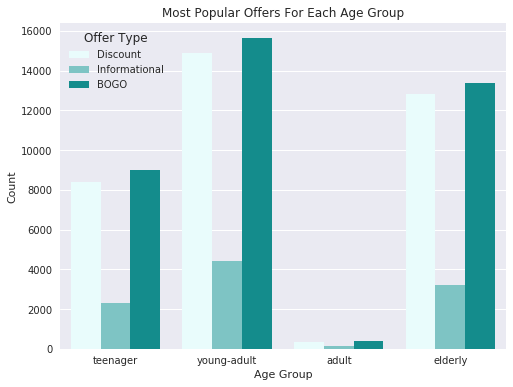

In [116]:
plt.figure(figsize=(8, 6))
Most_Popular_Offers = sns.countplot(x="age_group", hue="offer_type", data=df_merged_portfolio_transcript_profile , color = '#00A0A0')
plt.title('Most Popular Offers For Each Age Group')
plt.ylabel('Count')
plt.xlabel('Age Group')
xlabels = ['teenager','young-adult','adult','elderly']
Most_Popular_Offers.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

We can see that BOGO offers are the most popular among all age groups, Then Discount Offers. The least offer is the informational offers

## Which Channel Provided The Most Offers To Customers? 

In [117]:
# Creating a dataframe containing the various channels and the number of notifications
Channel_Offers= pd.DataFrame(df_merged_portfolio_transcript_profile[['channel_web','channel_email','channel_mobile','channel_social']].sum())
Channel_Offers.columns = ['Number of Notifications']
Channel_Offers

,Number of Notifications
channel_web,68981
channel_email,84963
channel_mobile,79223
channel_social,59937


From the table , Provided The Most Offers To Customers through  the email channel. It is followed by mobile , web and finally social channel  

## What kind of promotions (offers) does each gender likes?

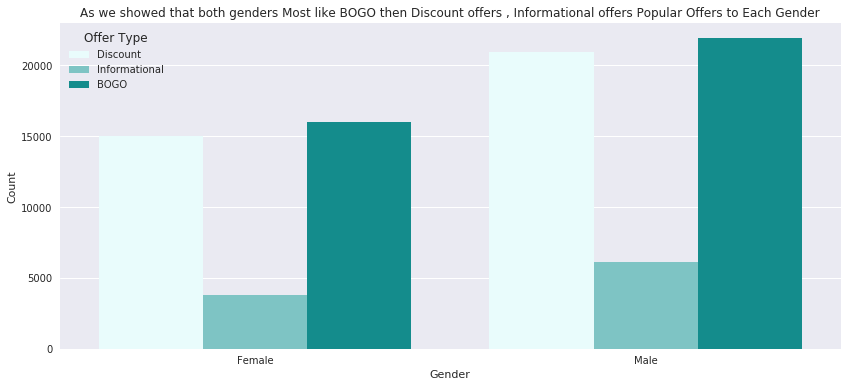

In [118]:
plt.figure(figsize=(14, 6))
gender_likes= sns.countplot(x='gender', hue="offer_type", data= df_merged_portfolio_transcript_profile[df_merged_portfolio_transcript_profile["gender"] != 3] ,color = '#00A0A0')
plt.title('As we showed that both genders Most like BOGO then Discount offers , Informational offers Popular Offers to Each Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
gender_likes.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

As we showed that both genders Most like BOGO then Discount offers , Informational offers

##  From all the offers the customers viewed, the number of offers they  completed?

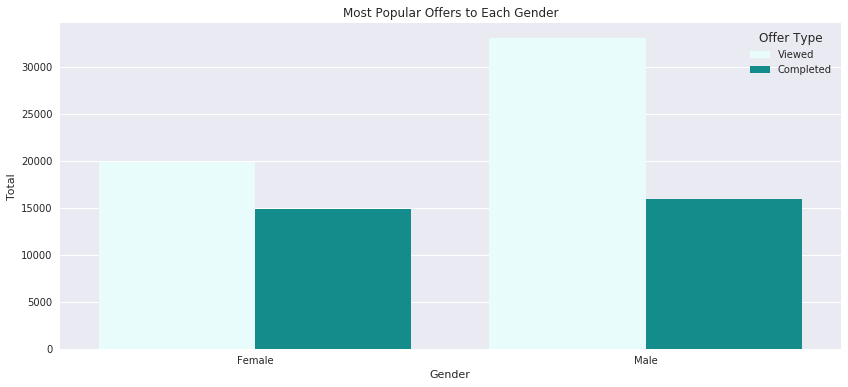

In [119]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="event", data= df_merged_portfolio_transcript_profile[df_merged_portfolio_transcript_profile["gender"] != 3] , color = '#00A0A0')
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

## How many new members Starbucks got each year?

In [120]:
df_merged_portfolio_transcript_profile['membership_year'] = df_merged_portfolio_transcript_profile['membership_year'].astype(int)

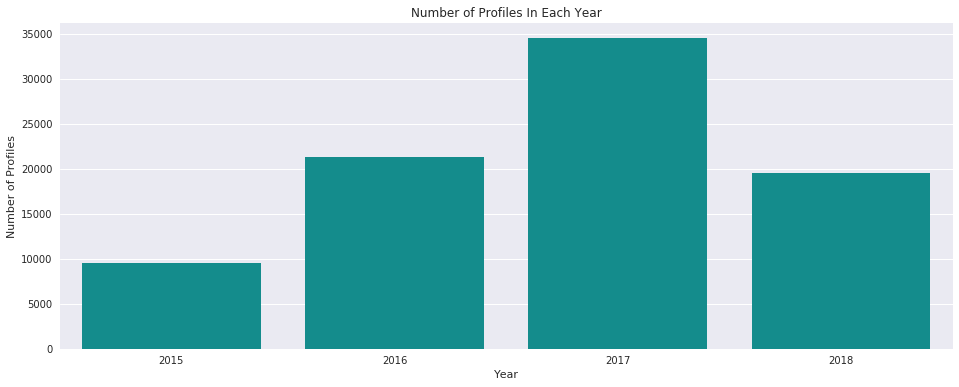

In [121]:
plt.figure(figsize=(16, 6))
sns.countplot(df_merged_portfolio_transcript_profile['membership_year'], color = '#00A0A0')
plt.title('Number of Profiles In Each Year')
plt.ylabel('Number of Profiles')
plt.xlabel('Year')
plt.xticks()
plt.show();

_____________________________________________________________________________________________________________________________

In [122]:
# Replacing the categorical values of the features by its corresponding numerical values
labels_event1 = df_merged_portfolio_transcript_profile['event'].astype('category').cat.categories.tolist()
replace_map_comp_event1 = {'event' : {k: v for k,v in zip(labels_event1,list(range(1,len(labels_event1)+1)))}}

labels_income1 = df_merged_portfolio_transcript_profile['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_range1 = {'income_range' : {k: v for k,v in zip(labels_income1,list(range(1,len(labels_income1)+1)))}}

labels_offer_type1 = df_merged_portfolio_transcript_profile['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type1 = {'offer_type' : {k: v for k,v in zip(labels_offer_type1,list(range(1,len(labels_offer_type1)+1)))}}

labels_age_group = df_merged_portfolio_transcript_profile['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}



df_merged_portfolio_transcript_profile.replace(replace_map_comp_event1, inplace=True)
df_merged_portfolio_transcript_profile.replace(replace_map_comp_offer_type1, inplace=True)
df_merged_portfolio_transcript_profile.replace(replace_map_comp_income_range1, inplace=True)
df_merged_portfolio_transcript_profile.replace(replace_map_comp_age_group, inplace=True)



In [123]:
df_merged_portfolio_transcript_profile.head()

,customer_id,event,time,offer_id,amount,reward_x,difficulty,duration,offer_type,reward_y,channel_web,channel_email,channel_mobile,channel_social,gender,age_group,income_range,membership_year,member_type
0,1,2,540,10,0.0,0,0.50,240,2,0.2,1,1,1,1,2,3,1,2017,3.0
1,1,1,528,10,0.0,0,0.50,240,2,0.2,1,1,1,1,2,3,1,2017,3.0
2,1,2,192,6,0.0,0,0.00,72,3,0.0,0,1,1,1,2,3,1,2017,3.0
3,1,1,414,9,0.0,0,0.25,120,1,0.5,1,1,1,1,2,3,1,2017,3.0
4,1,2,456,9,0.0,0,0.25,120,1,0.5,1,1,1,1,2,3,1,2017,3.0


# Data Modeling

In [124]:
df_merged_portfolio_transcript_profile.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward_x',
       'difficulty', 'duration', 'offer_type', 'reward_y', 'channel_web',
       'channel_email', 'channel_mobile', 'channel_social', 'gender',
       'age_group', 'income_range', 'membership_year', 'member_type'],
      dtype='object')

In [125]:
# Checking the data types 
df_merged_portfolio_transcript_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84963 entries, 0 to 91303
Data columns (total 19 columns):
customer_id        84963 non-null int64
event              84963 non-null int64
time               84963 non-null int64
offer_id           84963 non-null int64
amount             84963 non-null float64
reward_x           84963 non-null int64
difficulty         84963 non-null float64
duration           84963 non-null int64
offer_type         84963 non-null int64
reward_y           84963 non-null float64
channel_web        84963 non-null int64
channel_email      84963 non-null int64
channel_mobile     84963 non-null int64
channel_social     84963 non-null int64
gender             84963 non-null int64
age_group          84963 non-null int64
income_range       84963 non-null int64
membership_year    84963 non-null int64
member_type        84963 non-null float64
dtypes: float64(4), int64(15)
memory usage: 15.5 MB


In [126]:
# Converting the float data types of the few columns to the integer datatype before making ML prediction
df_merged_portfolio_transcript_profile["difficulty"] = df_merged_portfolio_transcript_profile["difficulty"].astype(int)
df_merged_portfolio_transcript_profile["member_type"] = df_merged_portfolio_transcript_profile["member_type"].astype(int)
df_merged_portfolio_transcript_profile["reward_y"] = df_merged_portfolio_transcript_profile["reward_y"].astype(int)
df_merged_portfolio_transcript_profile["amount"] = df_merged_portfolio_transcript_profile["amount"].astype(int)

In [127]:
# Checking the data types 
df_merged_portfolio_transcript_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84963 entries, 0 to 91303
Data columns (total 19 columns):
customer_id        84963 non-null int64
event              84963 non-null int64
time               84963 non-null int64
offer_id           84963 non-null int64
amount             84963 non-null int64
reward_x           84963 non-null int64
difficulty         84963 non-null int64
duration           84963 non-null int64
offer_type         84963 non-null int64
reward_y           84963 non-null int64
channel_web        84963 non-null int64
channel_email      84963 non-null int64
channel_mobile     84963 non-null int64
channel_social     84963 non-null int64
gender             84963 non-null int64
age_group          84963 non-null int64
income_range       84963 non-null int64
membership_year    84963 non-null int64
member_type        84963 non-null int64
dtypes: int64(19)
memory usage: 15.5 MB


In [128]:
df_merged_portfolio_transcript_profile.isnull().sum()/profile.shape[0]

customer_id        0.0
event              0.0
time               0.0
offer_id           0.0
amount             0.0
reward_x           0.0
difficulty         0.0
duration           0.0
offer_type         0.0
reward_y           0.0
channel_web        0.0
channel_email      0.0
channel_mobile     0.0
channel_social     0.0
gender             0.0
age_group          0.0
income_range       0.0
membership_year    0.0
member_type        0.0
dtype: float64

In [129]:
# Rename 'reward_x' column to 'reward'
df_merged_portfolio_transcript_profile.rename(columns ={'reward_x':'reward'}, inplace = True)

## Conclusion of the Test and Train datasets

In [130]:


# Assigining the X and Y variables before ML prediction

X = df_merged_portfolio_transcript_profile[['time','difficulty','duration','reward','offer_type','age_group','income_range','gender']]
Y = df_merged_portfolio_transcript_profile['event']



In [131]:
X.head()

,time,difficulty,duration,reward,offer_type,age_group,income_range,gender
0,540,0,240,0,2,3,1,2
1,528,0,240,0,2,3,1,2
2,192,0,72,0,3,3,1,2
3,414,0,120,0,1,3,1,2
4,456,0,120,0,1,3,1,2


In [132]:
# DataTypes of the X variable
X.dtypes

time            int64
difficulty      int64
duration        int64
reward          int64
offer_type      int64
age_group       int64
income_range    int64
gender          int64
dtype: object

In [133]:
Y.head()

0    2
1    1
2    2
3    1
4    2
Name: event, dtype: int64

In [134]:
# Splitting the data into the test and train based on 33% test size

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [135]:
# Printing the value count of the Y train variable after train and test split

y_train.value_counts()

2    35999
1    20926
Name: event, dtype: int64

In [136]:
# Printing the value count of the Y test variable after train and test split

y_test.value_counts()

2    17686
1    10352
Name: event, dtype: int64



For Now, several models will be tried , then the best model along them would be chosen. Followed by an implementation for a GridSearch to find the best parameters ( in order to improve the performance of the chosen model)

### 1. Decision Tree

In [137]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression

In [138]:
# DecisionTreeClassifier of our ML model

clf = DecisionTreeClassifier().fit(X_train, y_train)

y_predict = clf.predict(X_test)

print('------------------------------------------------------------')
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('------------------------------------------------------------')
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#printing the results
print('------------------------------------------------------------')
print ('Confusion Matrix :')
print('------------------------------------------------------------')
print(confusion_matrix(y_test, y_predict))
print('------------------------------------------------------------')
print ('Accuracy Score :',accuracy_score(y_test, y_predict))
print('------------------------------------------------------------')
print ('Report - ')
print('------------------------------------------------------------')
print (classification_report(y_test, y_predict))
print('------------------------------------------------------------')


------------------------------------------------------------
Accuracy of Decision Tree classifier on training set: 0.77
------------------------------------------------------------
Accuracy of Decision Tree classifier on test set: 0.67
------------------------------------------------------------
Confusion Matrix :
------------------------------------------------------------
[[ 5389  4963]
 [ 4220 13466]]
------------------------------------------------------------
Accuracy Score : 0.672480205435
------------------------------------------------------------
Report - 
------------------------------------------------------------
             precision    recall  f1-score   support

          1       0.56      0.52      0.54     10352
          2       0.73      0.76      0.75     17686

avg / total       0.67      0.67      0.67     28038

------------------------------------------------------------


### 2. Support Vector Machine

In [139]:
# SVC

from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)

y_predict = svm.predict(X_test)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))

print('------------------------------------------------------------')

print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))


#printing the results
print('------------------------------------------------------------')
print ('Confusion Matrix :')
print('------------------------------------------------------------')
print(confusion_matrix(y_test, y_predict))
print('------------------------------------------------------------')
print ('Accuracy Score :',accuracy_score(y_test, y_predict))
print('------------------------------------------------------------')
print ('Report - ')
print('------------------------------------------------------------')
print (classification_report(y_test, y_predict))
print('------------------------------------------------------------')

Accuracy of SVM classifier on training set: 0.64
------------------------------------------------------------
Accuracy of SVM classifier on test set: 0.65
------------------------------------------------------------
Confusion Matrix :
------------------------------------------------------------
[[  912  9440]
 [  513 17173]]
------------------------------------------------------------
Accuracy Score : 0.645017476282
------------------------------------------------------------
Report - 
------------------------------------------------------------
             precision    recall  f1-score   support

          1       0.64      0.09      0.15     10352
          2       0.65      0.97      0.78     17686

avg / total       0.64      0.65      0.55     28038

------------------------------------------------------------


### 3. linear regression

In [140]:
# Create linear regression object
linear_regression = LinearRegression()
# Fitting the Linear Regression model on the training data

linear_regression.fit(X_train, y_train)

y_predict = linear_regression.predict(X_test)

print('---------------------------------------------------------------')
print('Accuracy of Linear Regression classifier on training set: {:.2f}'
     .format(linear_regression.score(X_train, y_train)))
print('--------------------------------------------------------------')

print('Accuracy of Linear Regression classifier on test set: {:.2f}'
     .format(linear_regression.score(X_test, y_test)))
print('-------------------------------------------------------------')

---------------------------------------------------------------
Accuracy of Linear Regression classifier on training set: 0.10
--------------------------------------------------------------
Accuracy of Linear Regression classifier on test set: 0.10
-------------------------------------------------------------


### 4. Random Forest

In [141]:
from sklearn.ensemble import RandomForestClassifier

In [142]:
#Using the random forest classifier for the prediction

classifier=RandomForestClassifier()
classifier=classifier.fit(X_train,y_train)
predicted=classifier.predict(X_test)
 
#printing the results
print('------------------------------------------------------------')
print ('Confusion Matrix :')
print('------------------------------------------------------------')
print(confusion_matrix(y_test, predicted))
print('------------------------------------------------------------')
print ('Accuracy Score :',accuracy_score(y_test, predicted))
print('------------------------------------------------------------')
print ('Report - ')
print('------------------------------------------------------------')
print (classification_report(y_test, predicted))
print('------------------------------------------------------------')

------------------------------------------------------------
Confusion Matrix :
------------------------------------------------------------
[[ 4744  5608]
 [ 3780 13906]]
------------------------------------------------------------
Accuracy Score : 0.665168699622
------------------------------------------------------------
Report - 
------------------------------------------------------------
             precision    recall  f1-score   support

          1       0.56      0.46      0.50     10352
          2       0.71      0.79      0.75     17686

avg / total       0.65      0.67      0.66     28038

------------------------------------------------------------


### 5. K-Nearest Neighbors

In [143]:
# KNN Classifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_predict = knn.predict(X_test)


print('------------------------------------------------------------')
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('------------------------------------------------------------')
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))


#printing the results
print('------------------------------------------------------------')
print ('Confusion Matrix :')
print('------------------------------------------------------------')
print(confusion_matrix(y_test, y_predict))
print('------------------------------------------------------------')
print ('Accuracy Score :',accuracy_score(y_test, y_predict))
print('------------------------------------------------------------')
print ('Report - ')
print('------------------------------------------------------------')
print (classification_report(y_test, y_predict))

------------------------------------------------------------
Accuracy of K-NN classifier on training set: 0.73
------------------------------------------------------------
Accuracy of K-NN classifier on test set: 0.66
------------------------------------------------------------
Confusion Matrix :
------------------------------------------------------------
[[ 5044  5308]
 [ 4222 13464]]
------------------------------------------------------------
Accuracy Score : 0.660104144375
------------------------------------------------------------
Report - 
------------------------------------------------------------
             precision    recall  f1-score   support

          1       0.54      0.49      0.51     10352
          2       0.72      0.76      0.74     17686

avg / total       0.65      0.66      0.66     28038



### 6. LogisticRegression

In [144]:
# Logistic Regression of our ML model

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_predict = logreg.predict(X_test)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))


#printing the results
print('------------------------------------------------------------')
print ('Confusion Matrix :')
print('------------------------------------------------------------')
print(confusion_matrix(y_test, y_predict))
print('------------------------------------------------------------')
print ('Accuracy Score :',accuracy_score(y_test, y_predict))
print('------------------------------------------------------------')
print ('Report - ')
print('------------------------------------------------------------')
print (classification_report(y_test, y_predict))
print('------------------------------------------------------------')

Accuracy of Logistic regression classifier on training set: 0.64
Accuracy of Logistic regression classifier on test set: 0.65
------------------------------------------------------------
Confusion Matrix :
------------------------------------------------------------
[[ 2998  7354]
 [ 2599 15087]]
------------------------------------------------------------
Accuracy Score : 0.645017476282
------------------------------------------------------------
Report - 
------------------------------------------------------------
             precision    recall  f1-score   support

          1       0.54      0.29      0.38     10352
          2       0.67      0.85      0.75     17686

avg / total       0.62      0.65      0.61     28038

------------------------------------------------------------


# Model Evaluation

In [145]:
# creating the variables that will be used to fill the results table
models = [svm, linear_regression , clf , knn, logreg , classifier]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]

In [146]:
# structuring a table to view the results of the different model tried above
results = [training_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy'])

In [147]:
# show the results dataframe 
results_df

,SVC,LinearRegression,DecisionTreeClassifier,KNeighborsClassifier,LogisticRegression,RandomForestClassifier
Training Accuracy,64.465525,9.825427,76.813351,73.34563,64.381203,76.326746


the above table, shows the accuracy score related with using various ML models . As presented on the table,DecisionTreeClassifier giving us the better scoring and can be used to predict our response to a customer based on the offer viewed in the Starbucks App. Since

# Conclusion

Through this project, I tried to analyze, visualize and make prediction on the Starbucks customers data set. First I explored the data and made some changes before start the analysis. Then I did an exploratory analysis on the data after cleaning. From the exploratory analysis::
Customers fall into one of three 'gender' categories, according to the available data ( M, F, and O).Male Customers (8484 men) are more than Female Customers(6129 women) and , 212 customers have selected "O" as their gender.The BOGO offers are the most popular among all age groups, Then Discount Offers. The least offer is the informational offers.I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.Provided The Most Offers To Customers through the email channel. It is followed by mobile , web and finally social channel .That both genders Most like BOGO then Discount offers , Informational offers. Finally, I used ML modeling feeding in the data from three combine data. The Decision Tree Classifier had the best prediction accuracy score.In conclusion, starbucks should place a greater emphasis on Buy One Get One and Discount offers, as they motivate clients to purchase more.

# Improvement:



We can create a model that predicts which demographic groups will buy even if they aren't offered anything.
Is it possible to create a model that can anticipate which kind of offers should be sent to which customers?

Creating a model that can predict which clients are likely to buy in the first place ( regardless if there is an offer or not) 